# Data Cleanup for Various Future Datafeeds

# Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0

!python --version

Python 3.11.8


# Cloud Environment Setup

In [2]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import glob
from datetime import datetime
from pandas.tseries.offsets import BDay, Day
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

warnings.filterwarnings("ignore")

CLEAN_DATA_PATH = f".{os.sep}data"
DATA_PATH = f".{os.sep}data{os.sep}unstructureddata"
print("running localhost!")

running localhost!


# Get Data

In [3]:
from constants import *

class StockFeat:
    DATETIME = "Datetime"
    OPEN = "Open"
    HIGH = "High"
    LOW = "Low"
    CLOSE = "Close"
    VOLUME = "Volume"
    list = [OPEN, HIGH, LOW, CLOSE, VOLUME]


PERIOD_PD_FREQ = {
    YFinanceOptions.M1: '1T',
    YFinanceOptions.M15: '15T',
}

INTERVAL = YFinanceOptions.M15
DATE_TIME_FORMAT = "%Y-%m-%d"
END_DATE = pd.Timestamp(datetime.now()).strftime(DATE_TIME_FORMAT)
START_DATE =  pd.Timestamp(datetime.now() - Day(YFinanceOptions.MIN15_RANGE)).strftime(DATE_TIME_FORMAT)

print(FUTS)

['ZC', 'ZL', 'KE', 'ZS', 'ZM', 'ZW', 'LE', 'HE', 'GF', 'GC', 'SI', 'HG', 'PL', 'PA', 'CL', 'NG', 'HO', 'ES', 'NQ', 'VX', 'RTY', '2Y', '10Y']


In [4]:
import yfinance as yf
from scipy.stats import skew, kurtosis

def get_yf_tickers_df(tickers_symbols, start, end, interval=INTERVAL, datadir=DATA_PATH):
    tickers = {}
    earliest_end= pd.to_datetime(datetime.strptime(end,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    latest_start = pd.to_datetime(datetime.strptime(start,YFinanceOptions.DATE_TIME_FORMAT)).tz_localize("UTC")
    os.makedirs(datadir, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        print(f"Checking file: {cached_file_path}")
        if os.path.exists(cached_file_path):
            print(f"loading from {cached_file_path}")
            df = pd.read_csv(cached_file_path, parse_dates= True, index_col=0)
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
            assert len(df) > 0, "Empty data"
        else:
            df = yf.download(
                symbol,
                start=start,
                end=end,
                progress=True,
                interval=interval
            )
            assert len(df) > 0, "No data pulled"
            try:
                df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
            except Exception as e:
                df.index = pd.to_datetime(df.index).tz_convert('UTC')
        # Use adjusted close if available.
        if 'Adj Close' in df.columns:
            assert 'Close' in df.columns
            df.drop(columns=['Adj Close'], inplace=True)
            # df.rename(columns={'Adj Close': 'Close'}, inplace=True)
        min_date = df.index.min()
        max_date = df.index.max()
        nan_count = df["Close"].isnull().sum()
        skewness = round(skew(df["Close"].dropna()), 2)
        kurt = round(kurtosis(df["Close"].dropna()), 2)
        outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
        print(
            f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
        )
        tickers[symbol] = df

        if min_date > latest_start:
            latest_start = min_date
        if max_date < earliest_end:
            earliest_end = max_date

    nyse = mcal.get_calendar('CME_Agriculture')
    schedule = nyse.schedule(start_date=latest_start, end_date=earliest_end)
    all_trading_days = mcal.date_range(schedule, frequency=PERIOD_PD_FREQ[interval], tz='UTC', normalize=True)

    for symbol, df in tickers.items():
        df_filtered = df[(df.index >= latest_start) & (df.index <= earliest_end)]
        df_reindexed = df_filtered.reindex(all_trading_days, method='nearest')
        df_reindexed.index = pd.to_datetime(df_reindexed.index)
        df_reindexed = df_reindexed[~df_reindexed.index.duplicated(keep='first')]
        df_reindexed.index.name = 'Date'
        df_reindexed = df_reindexed.bfill().ffill()
        tickers[symbol] = df_reindexed

        cached_file_path = f"{datadir}/{symbol}-{start.split(' ')[0]}-{end.split(' ')[0]}-{interval}.csv"
        if not os.path.exists(cached_file_path):
            df_reindexed.to_csv(cached_file_path, index=True)

    return tickers, latest_start, earliest_end

def load_all_csv_files(tickers_symbols=FUTS, interval=INTERVAL, datadir=DATA_PATH):
    tickers = {}
    earliest_end = None
    latest_start = None

    for root, dirs, files in os.walk(datadir):
        symbol = os.path.basename(root)
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                print(f"Loading {file_path}")
                df = pd.read_csv(file_path, parse_dates=True, index_col=0)
                try:
                    df.index = pd.to_datetime(df.index).tz_localize('US/Central').tz_convert('UTC')
                except Exception as e:
                    df.index = pd.to_datetime(df.index).tz_convert('UTC')

                symbol = symbol.capitalize()
                df.columns = [f"{col.capitalize()}" for col in df.columns]

                min_date = df.index.min()
                max_date = df.index.max()
                nan_count = df[f"Close"].isnull().sum()
                skewness = round(skew(df[f"Close"].dropna()), 2)
                kurt = round(kurtosis(df[f"Close"].dropna()), 2)
                outliers_count = (df[f"Close"] > df[f"Close"].mean() + (3 * df[f"Close"].std())).sum()
                print(
                    f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count}, nan_count: {nan_count}"
                )

                df.index.name = 'Date'
                tickers[symbol] = df
                if latest_start is None or min_date > latest_start:
                    latest_start = min_date
                if earliest_end is None or max_date < earliest_end:
                    earliest_end = max_date

                cached_file_path = f"{datadir}/{symbol}-{latest_start.strftime('%Y%m%d').split(' ')[0]}-{earliest_end.strftime('%Y%m%d').split(' ')[0]}-{interval}.csv"
                df.to_csv(cached_file_path, index=True)

    return tickers, latest_start, earliest_end

# This loads a collection of files (e.g. from IBKR)
tickers, latest_start, earliest_end = load_all_csv_files()

# This gets from YFinance
# tickers, latest_start, earliest_end = get_yf_tickers_df(FUTS, start=START_DATE, end=END_DATE)

Loading .\data\unstructureddata\10y-20231229-20240126-15m.csv
Unstructureddata => min_date: 2023-12-29 01:00:00+00:00, max_date: 2024-01-26 22:45:00+00:00, kurt:-0.74, skewness:-0.24, outliers_count:0, nan_count: 0
Loading .\data\unstructureddata\10y-20240129-20240126-15m.csv
Unstructureddata => min_date: 2024-01-29 00:00:00+00:00, max_date: 2024-02-27 00:45:00+00:00, kurt:-0.4, skewness:-0.66, outliers_count:0, nan_count: 0
Loading .\data\unstructureddata\10y-20240227-20240126-15m.csv
Unstructureddata => min_date: 2024-02-27 01:00:00+00:00, max_date: 2024-03-28 00:45:00+00:00, kurt:-0.88, skewness:-0.5, outliers_count:0, nan_count: 0
Loading .\data\unstructureddata\10y-20240328-20240126-15m.csv
Unstructureddata => min_date: 2024-03-28 01:00:00+00:00, max_date: 2024-04-26 22:45:00+00:00, kurt:-1.07, skewness:-0.48, outliers_count:0, nan_count: 0
Loading .\data\unstructureddata\10y-20240416-20240126-15m.csv
Unstructureddata => min_date: 2024-04-16 02:00:00+00:00, max_date: 2024-05-27 01

De-duplicate and combine dataframes.

# Clean Data

In [5]:
for ticker in FUTS:
    file_pattern = f'{ticker}*.csv'
    files = glob.glob(f"{DATA_PATH}{os.sep}{ticker}*-{INTERVAL}.csv")
    assert files and len(files) > 0

    dataframes = []
    for file in files:
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        dataframes.append(df)

    combined_df = pd.concat(dataframes)
    combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
    combined_df.sort_index(inplace=True)
    combined_df.to_csv(f'{DATA_PATH}{os.sep}{ticker}-combined-{INTERVAL}.csv')

In [6]:
def get_prefix(filename):
    prefix = filename.split(os.sep)[-1].split("-")[0]
    return prefix

files = glob.glob(f'{DATA_PATH}{os.sep}*-combined-{INTERVAL}.csv')
assert files and len(files) > 0

fut_tickers = []
df_list = []

for f in files:
    print(f)
    prefix = get_prefix(f)
    fut_tickers.append(prefix)
    df_temp = pd.read_csv(f, index_col="Date", parse_dates=True)
    # TODO: Use bid ask here.
    df_temp["Spread"] = df_temp["High"] - df_temp["Low"]

    df_temp.columns = [prefix + "_" + col for col in df_temp.columns]
    df_temp = df_temp.apply(
        pd.to_numeric, errors="coerce"
    )

    df_list.append(df_temp)

.\data\unstructureddata\10Y-combined-15m.csv
.\data\unstructureddata\2Y-combined-15m.csv
.\data\unstructureddata\CL-combined-15m.csv
.\data\unstructureddata\ES-combined-15m.csv
.\data\unstructureddata\GC-combined-15m.csv
.\data\unstructureddata\GF-combined-15m.csv
.\data\unstructureddata\HE-combined-15m.csv
.\data\unstructureddata\HG-combined-15m.csv
.\data\unstructureddata\HO-combined-15m.csv
.\data\unstructureddata\KE-combined-15m.csv
.\data\unstructureddata\LE-combined-15m.csv
.\data\unstructureddata\NG-combined-15m.csv
.\data\unstructureddata\NQ-combined-15m.csv
.\data\unstructureddata\PA-combined-15m.csv
.\data\unstructureddata\PL-combined-15m.csv
.\data\unstructureddata\RTY-combined-15m.csv
.\data\unstructureddata\SI-combined-15m.csv
.\data\unstructureddata\VX-combined-15m.csv
.\data\unstructureddata\ZC-combined-15m.csv
.\data\unstructureddata\ZL-combined-15m.csv
.\data\unstructureddata\ZM-combined-15m.csv
.\data\unstructureddata\ZS-combined-15m.csv
.\data\unstructureddata\ZW-com

In [7]:
futs_df = pd.concat(df_list, axis=1)
try:
    futs_df.index = futs_df.index.tz_localize("GMT")
except Exception as e:
    print(e)
    # Probably already TZ aware
futs_df.sort_index(inplace=True)
futs_df = futs_df.iloc[futs_df.notnull().all(axis=1).argmax() :]
futs_df.interpolate(method="time", inplace=True)

assert not futs_df.isnull().any().any()
print(fut_tickers)
print(f"Dataset Shape: {futs_df.shape}")

futs_df.head(2)

Already tz-aware, use tz_convert to convert.
['10Y', '2Y', 'CL', 'ES', 'GC', 'GF', 'HE', 'HG', 'HO', 'KE', 'LE', 'NG', 'NQ', 'PA', 'PL', 'RTY', 'SI', 'VX', 'ZC', 'ZL', 'ZM', 'ZS', 'ZW']
Dataset Shape: (1786, 184)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2Y_Open,2Y_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-29 15:30:00+00:00,4.616,4.625,4.616,4.621,43.0,13.0,4.6198,0.009,4.924,4.933,...,1186.225,7.00,617.0,619.25,614.25,615.0,7351.0,2416.0,616.800,5.0
2024-04-29 15:45:00+00:00,4.626,4.628,4.623,4.628,57.0,19.0,4.6252,0.005,4.903,4.903,...,1187.200,6.25,615.0,615.00,611.00,611.0,4135.0,1317.0,612.875,4.0


In [8]:
PRICE_COLS =["Close", "Open", "High", "Low", "Spread"]
def create_fut_rets_df(df, price_types = PRICE_COLS):
    log_data = {}
    pct_change_data = {}

    for price_type in tqdm(price_types):
        for column in tqdm(df.columns):
            if price_type in column:
                log_data[f"{column}_lp"] = np.log(df[column])
                pct_change_data[f"{column}_pc"] = df[column].pct_change() * 100
    log_fut_df = pd.DataFrame(log_data, index=df.index).bfill()
    pct_changes_df = pd.DataFrame(pct_change_data, index=df.index).bfill()
    combined_df = pd.concat([log_fut_df, pct_changes_df], axis=1)

    return combined_df

fut_rets_df = create_fut_rets_df(futs_df)
fut_rets_df.head(2)

100%|██████████| 5/5 [00:00<00:00, 136.42it/s]


,10Y_Close_lp,2Y_Close_lp,CL_Close_lp,ES_Close_lp,GC_Close_lp,GF_Close_lp,HE_Close_lp,HG_Close_lp,HO_Close_lp,KE_Close_lp,...,PA_Spread_pc,PL_Spread_pc,RTY_Spread_pc,SI_Spread_pc,VX_Spread_pc,ZC_Spread_pc,ZL_Spread_pc,ZM_Spread_pc,ZS_Spread_pc,ZW_Spread_pc
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-29 15:30:00+00:00,1.530611,1.595947,4.418238,8.544711,7.758761,5.564329,4.650860,1.531044,0.951272,6.48578,...,0.0,-14.035088,-55.339806,-45.16129,80.0,0.0,-24.0,-12.121212,-10.714286,-20.0
2024-04-29 15:45:00+00:00,1.532125,1.589847,4.417876,8.545295,7.760126,5.566817,4.653484,1.531260,0.951619,6.48196,...,0.0,-14.035088,-55.339806,-45.16129,80.0,0.0,-24.0,-12.121212,-10.714286,-20.0


In [9]:
futs_df.to_csv(f"{CLEAN_DATA_PATH}{os.sep}futures_{INTERVAL}.csv")

# EDA

## Skew, Kurosis and Outliers

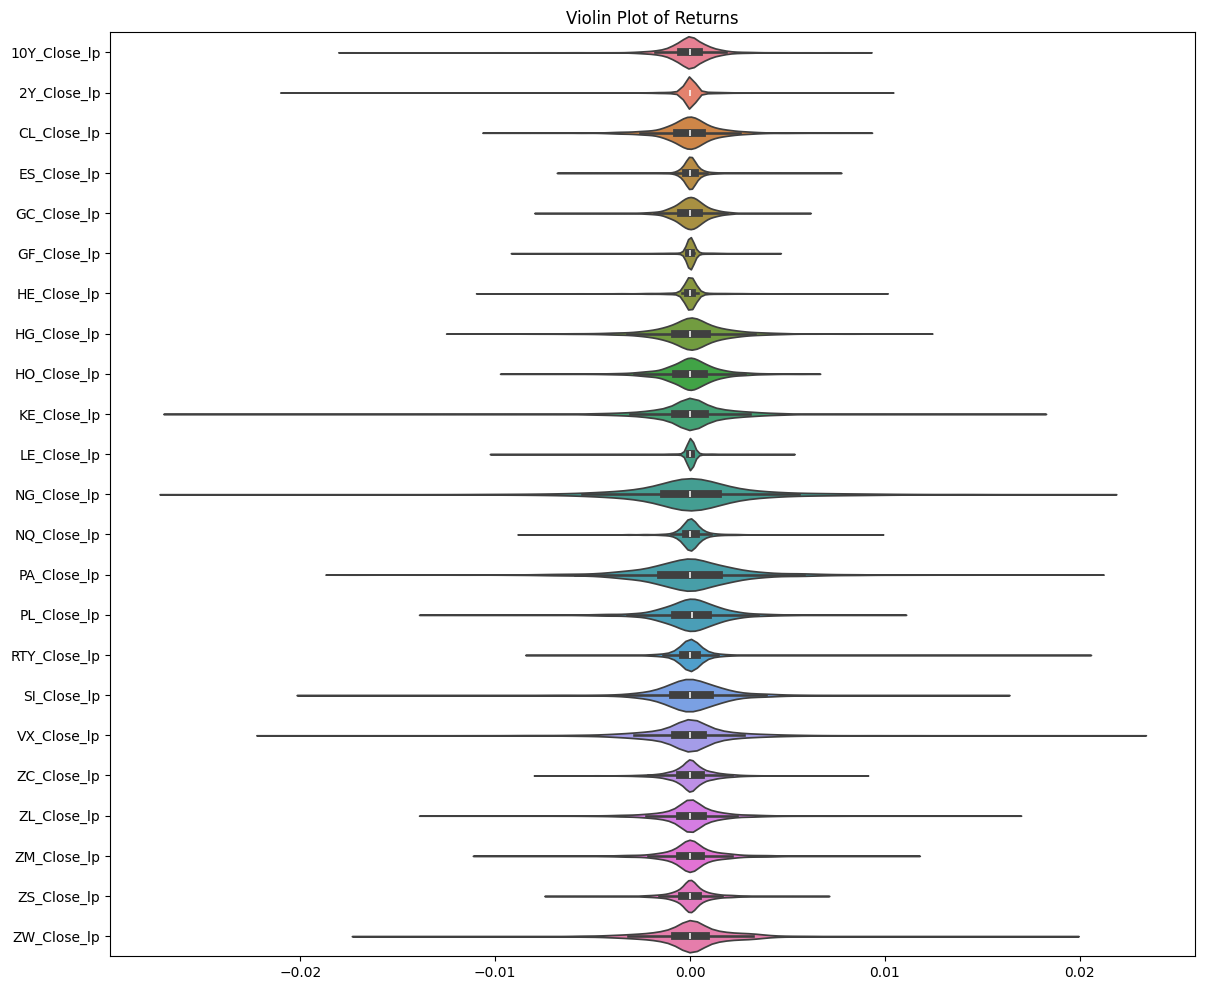

In [10]:
fut_lp = fut_rets_df.filter(regex="^.*Close_lp")
fut_lr = fut_lp.diff(1).fillna(0)
plt.figure(figsize=(14, 12))
ax = sns.violinplot(data=fut_lr, orient='h', scale='width')

plt.title("Violin Plot of Returns")
plt.show()

## Data Mining for Correlations


## Autoregressive

In [11]:
from statsmodels.tsa.stattools import pacf
from tqdm import tqdm
from scipy.stats import norm

def get_significant_lags(series, alpha=0.05):
    pacf_values = pacf(series.dropna(), nlags=40)
    n = len(series.dropna())
    z_critical = norm.ppf(1 - alpha / 2)  # two-tailed test
    critical_value = z_critical / np.sqrt(n) # the PCF value
    significant_lags = [i for i, p in enumerate(pacf_values) if abs(p) > critical_value]
    significant_lags = significant_lags[2:] # Drop lag 0,1, its always AR
    significant_pacf_values = [p for p in pacf_values if abs(p) > critical_value]
    significant_pacf_values = significant_pacf_values[2:]
    return significant_lags, significant_pacf_values

def get_ar_stats(df, alpha=0.05):
    df.index = pd.DatetimeIndex(df.index).to_period('T')
    ar_results = []
    for col in tqdm(df.columns, desc="get_ar_stats"):
        significant_lags, significant_pacf_values = get_significant_lags(df[col], alpha)
        ar_results.append({
            'Futs': col,
            'Lags': significant_lags,
            'PACF Values': significant_pacf_values
        })

    ar_df = pd.DataFrame(ar_results)
    return ar_df

ar_df = get_ar_stats(futs_df.filter(regex='_Close$'))
ar_df


get_ar_stats: 100%|██████████| 23/23 [00:00<00:00, 64.67it/s]


,Futs,Lags,PACF Values
0,10Y_Close,"[3, 4, 7, 10, 23, 34, 35]","[0.06245705803326645, 0.058560605233971955, 0...."
1,2Y_Close,"[2, 5, 6, 22]","[0.08968116423155192, 0.07307303400539598, 0.0..."
2,CL_Close,"[5, 9]","[0.07222472152771525, -0.0631994306377583]"
3,ES_Close,"[5, 6, 17, 19, 20, 23, 34, 36, 37]","[0.06975034488763088, 0.09545242611426054, -0...."
4,GC_Close,"[3, 5, 10, 11, 15, 25, 28, 33, 38]","[0.08041306029528693, 0.06637098006308562, -0...."
5,GF_Close,"[3, 4, 5, 7]","[0.07034286783568035, -0.09492248363580302, 0...."
6,HE_Close,"[2, 4, 5]","[-0.0947370342857519, -0.046753538798337546, -..."
7,HG_Close,"[5, 14, 15, 17, 18, 20, 21, 22, 24, 27, 28, 31...","[-0.0749506330166511, 0.05046708834820663, -0...."
8,HO_Close,"[5, 9]","[0.0806809792333885, -0.05404526462782164]"
9,KE_Close,[23],[-0.0464860082556383]


In [12]:
def find_common_lags(ar_df):
    lag_dict = {}
    for index, row in ar_df.iterrows():
        for lag in row['Lags']:
            if lag in lag_dict:
                lag_dict[lag].append(row['Futs'])
            else:
                lag_dict[lag] = [row['Futs']]

    common_lags = {lag: futs for lag, futs in lag_dict.items() if len(futs) > 1}

    common_lags_df = pd.DataFrame(list(common_lags.items()), columns=['Lag', 'Futs'])
    common_lags_df['Futs'] = common_lags_df['Futs'].apply(lambda futs: ', '.join(futs))

    return common_lags_df


commmon_ar_df = find_common_lags(ar_df)
commmon_ar_df

,Lag,Futs
0,3,"10Y_Close, GC_Close, GF_Close, LE_Close, NG_Cl..."
1,4,"10Y_Close, GF_Close, HE_Close, LE_Close, PA_Cl..."
2,7,"10Y_Close, GF_Close, LE_Close, PA_Close, PL_Cl..."
3,10,"10Y_Close, GC_Close"
4,23,"10Y_Close, ES_Close, KE_Close, NQ_Close, RTY_C..."
5,34,"10Y_Close, ES_Close, HG_Close"
6,35,"10Y_Close, PA_Close"
7,2,"2Y_Close, HE_Close, NG_Close, PA_Close, SI_Clo..."
8,5,"2Y_Close, CL_Close, ES_Close, GC_Close, GF_Clo..."
9,6,"2Y_Close, ES_Close, NQ_Close, PA_Close, VX_Close"


## Correlations between Futures

In [13]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
from itertools import combinations

LAGS = [1, 4, 16, 32]
MAX_DIFF = 2


def make_stationary(series, max_diff=MAX_DIFF):
    result = adfuller(series.dropna(), autolag="AIC")
    p_value = result[1]
    if p_value < 0.05:
        return series, 0

    diff_count = 0
    differenced_series = series.copy()
    while p_value >= 0.05 and diff_count < max_diff:
        differenced_series = differenced_series.diff().dropna()
        result = adfuller(differenced_series, autolag="AIC")
        p_value = result[1]
        diff_count += 1
        if p_value < 0.05:
            break

    return differenced_series, diff_count


def calculate_correlations(data, lags=LAGS, alpha=0.05, corr_threshold=0.25):
    correlations = {}

    rets = data.filter(regex="(_Close_lp)$")
    pairs = list(combinations(rets.columns, 2))
    for col1, col2 in tqdm(pairs, desc="calculate_correlations", total=len(pairs)):
        series1, _ = make_stationary(rets[col1])
        series2, _ = make_stationary(rets[col2])

        for lag in lags:
            lagged_series2 = series2.shift(lag).dropna()
            truncated_series1 = series1.iloc[lag:]

            if len(truncated_series1) == 0 or len(truncated_series1) != len(lagged_series2):
                continue

            corr, p_value = pearsonr(truncated_series1, lagged_series2)
            if p_value < alpha and abs(corr) >= corr_threshold:
                correlations[((col1, col2), lag)] = (corr, p_value)

    return correlations

correlation_df = []
correlation_results = calculate_correlations(fut_rets_df)
if len(correlation_results) > 0:
    correlation_df = pd.DataFrame.from_dict(
        correlation_results, orient="index", columns=["Correlation", "P-Value"]
    )
    correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

correlation_df

calculate_correlations: 100%|██████████| 253/253 [00:45<00:00,  5.54it/s]


,Correlation,P-Value
"((CL_Close_lp, HO_Close_lp), 1)",0.916544,0.0
"((CL_Close_lp, HO_Close_lp), 4)",0.900852,0.0
"((CL_Close_lp, HO_Close_lp), 16)",0.851657,0.0
"((CL_Close_lp, HO_Close_lp), 32)",0.789372,0.0


## Data Mining for Co-Integrations

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import itertools
from numpy.linalg import LinAlgError

subsets = {
        'Market': MARKET_FUTS,
        'Metals': METALS_FUTS,
        'Energy': ENERGY_FUTS,
        'Agri': AGRI_FUTS,
        'All': FUTS
    }

def johansen_cointegration_test(df, alpha=0.05):
    assert df.shape[1] > 0

    data = df.values
    johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)

    trace_stat = johansen_result.lr1
    trace_crit_values = johansen_result.cvt

    def get_crit_index(alpha):
        alpha_levels = [0.10, 0.05, 0.01]
        if alpha in alpha_levels:
            return alpha_levels.index(alpha)
        else:
            raise ValueError(f"Alpha {alpha} out of valid range {alpha_levels}")

    crit_index = get_crit_index(alpha)
    num_cointegrated_vectors = sum(trace_stat > trace_crit_values[:, crit_index])
    return num_cointegrated_vectors, johansen_result

def run_johansen_on_subsets(fut_rets_df):
    results = []

    # Test each subset
    for subset_name, tickers in subsets.items():
        cols = [t+"_Close_lp" for t in tickers]
        filtered_df = fut_rets_df[cols]
        if len(filtered_df.columns) < 2:
            continue
        try:
            num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
            results.append({
                'Subset': subset_name,
                'Coints': num_coint_vectors
            })
        except LinAlgError as e:
            results.append({
                'Subset': subset_name,
                'Coints': None,
            })

    # Test combinations of subsets
    subset_keys = list(subsets.keys())
    for i in range(2, len(subset_keys) + 1):
        for combination in itertools.combinations(subset_keys, i):
            combined_name = ' + '.join(combination)
            combined_tickers = list(itertools.chain.from_iterable(subsets[key] for key in combination))
            cols = [t+"_Close_lp" for t in combined_tickers]
            filtered_df = fut_rets_df[cols]
            if len(filtered_df.columns) < 2 or len(filtered_df.columns) > 12:
                continue
            try:
                num_coint_vectors, johansen_result = johansen_cointegration_test(filtered_df)
                results.append({
                    'Subset': combined_name,
                    'Coints': num_coint_vectors
                })
            except LinAlgError as e:
                results.append({
                    'Subset': combined_name,
                    'Coints': 0,
                })

    return pd.DataFrame(results)

results = run_johansen_on_subsets(fut_rets_df)
results[results["Coints"] > 1].sort_values("Coints")

C:\Users\adamd\AppData\Local\Temp\ipykernel_34628\1267306016.py:17: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)


,Subset,Coints
0,Market,2
5,Market + Metals,2
8,Energy + Agri,2


In [15]:
def get_all_futs_in_coint_subsets():
    coint_subset = set()
    for subset in results[results["Coints"] > 1]['Subset']:
        futures = subset.split(' + ')
        for future in futures:
            coint_subset.update(subsets[future])

    return coint_subset

# We can get a subset of all coint futures across industries, though we
# know there is strong coint in the equities and agri futures,
COINT_FUTS = get_all_futs_in_coint_subsets()
COINT_FUTS = MARKET_FUTS + AGRI_FUTS
print(COINT_FUTS)

['ES', 'NQ', 'VX', 'RTY', '2Y', '10Y', 'ZC', 'ZL', 'KE', 'ZS', 'ZM', 'ZW', 'LE', 'HE', 'GF']


In [16]:
from statsmodels.tsa.stattools import coint

def pairwise_cointegration_test(df, coint_cols, alpha=0.05):
    tickers = [t+"_Close_lp" for t in coint_cols]
    results = []

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            series1 = df[tickers[i]]
            series2 = df[tickers[j]]
            score, p_value, _ = coint(series1, series2)
            if p_value < alpha:
                results.append({
                    'Ticker1': tickers[i].split('_')[0],
                    'Ticker2': tickers[j].split('_')[0],
                    'P-Value': p_value
                })

    results_df = pd.DataFrame(results)
    return results_df


pairwise_coint_results = pairwise_cointegration_test(fut_rets_df, COINT_FUTS)

if not pairwise_coint_results.empty:
    pairwise_coint_results = pairwise_coint_results.sort_values(by='P-Value')
    print(pairwise_coint_results)
else:
    print("No meaningful pairwise cointegration within the supplied alpha")

  Ticker1 Ticker2   P-Value
0     RTY     10Y  0.012608
1      ZL      ZW  0.046086


## Cummulative Returns Visualizations

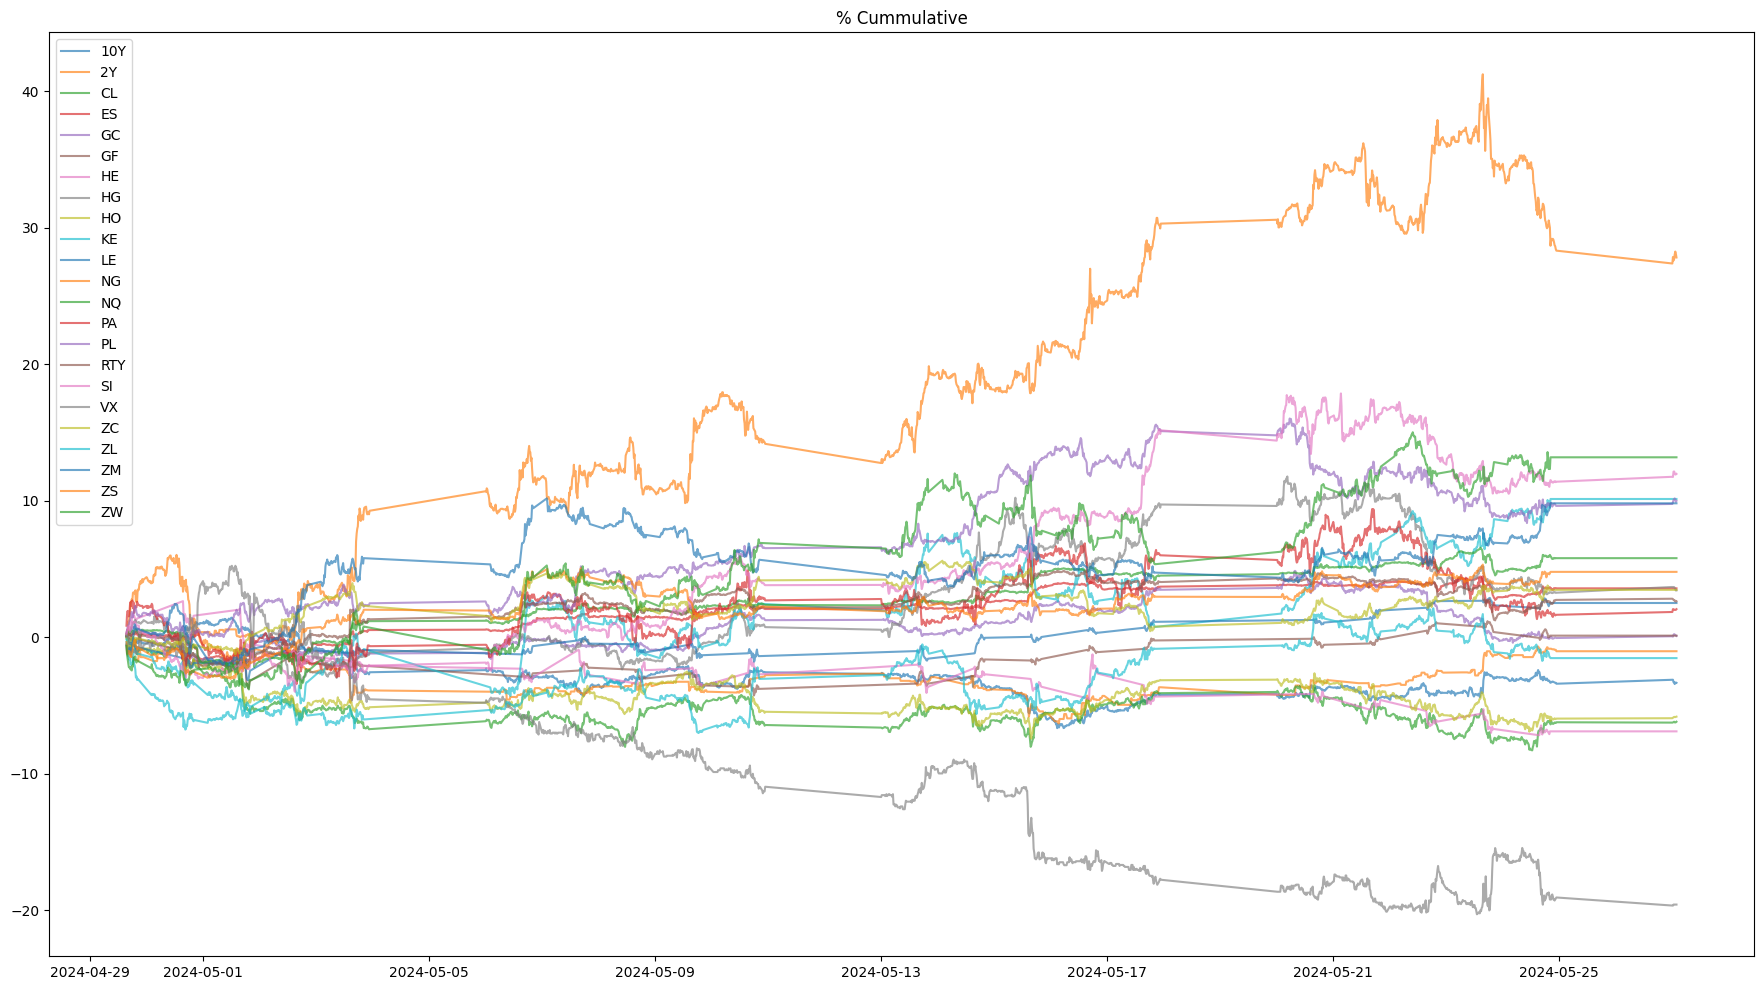

In [17]:
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc"):
        fut_rets_df[c + "_c"] = fut_rets_df[c].cumsum()

# Plotting
plt.figure(figsize=(22, 12))
for c in fut_rets_df.columns:
    if c.endswith("_Close_pc_c"):
        plt.plot(fut_rets_df.index, fut_rets_df[c], label=c.replace("_Close_pc_c", ""), alpha=0.65)
plt.title("% Cummulative")
plt.legend()
plt.show()

## Distributions

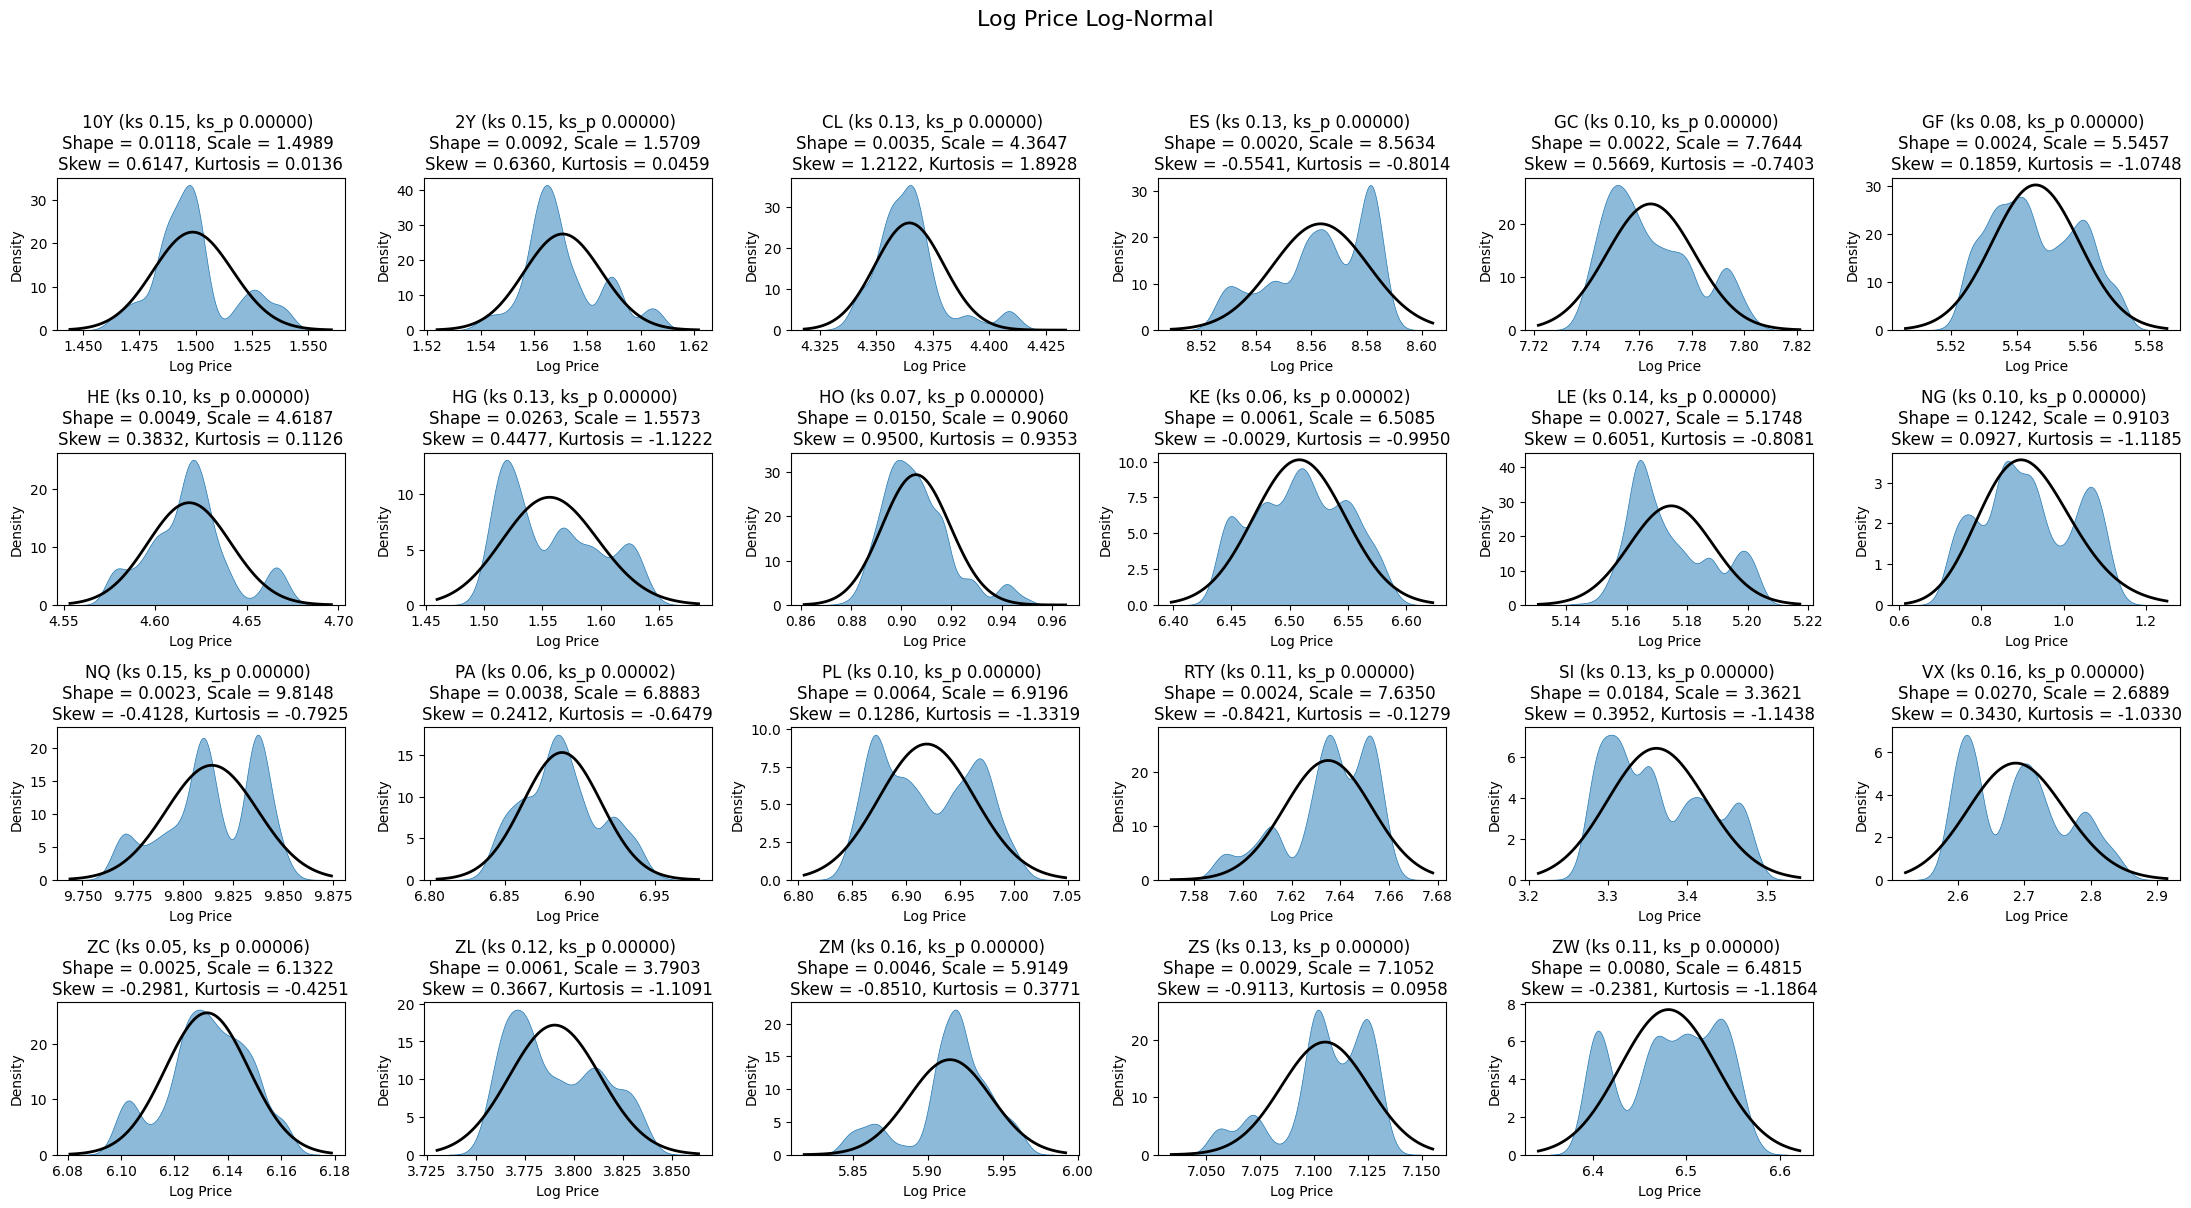

In [21]:
from scipy.stats import lognorm, kstest

def plot_lognorm(df):
    columns = df.filter(regex="(_Close(_lp)?)$").columns
    n_cols = len(columns)
    n_cols_adjusted = n_cols // 2 + (n_cols % 2)
    assert len(columns) > 0 and n_cols_adjusted > 0

    fig, axes = plt.subplots(nrows=max(n_cols_adjusted // 2, 1), ncols=max(n_cols_adjusted // 2, 1), figsize=(22, 18))
    axes = axes.flatten()
    fig.suptitle("Log Price Log-Normal", fontsize=16)
    for ax, column in zip(axes, columns):
        data = df[column].dropna()
        sns.kdeplot(
            data,
            fill=True,
            common_norm=False,
            alpha=0.5,
            linewidth=0.5,
            ax=ax
        )

        shape, loc, scale = lognorm.fit(data, floc=0)
        # Kolmogorov-Smirnov Test (KS Test)
        ks_stat, ks_p_value = kstest(data, 'lognorm', args=(shape, loc, scale))

        xmin, xmax = ax.get_xlim()

        x = np.linspace(xmin, xmax, 100)
        p = lognorm.pdf(x, shape, loc, scale)
        ax.plot(x, p, 'k', linewidth=2)

        data_skew = skew(data)
        data_kurtosis = kurtosis(data)

        title = (
            f"{column.split('_')[0]} (ks {ks_stat:.02f}, ks_p {ks_p_value:.05f}) \n"
            f"Shape = {shape:.04f}, Scale = {scale:.04f} \n"
            f"Skew = {data_skew:.04f}, Kurtosis = {data_kurtosis:.04f}"
        )
        ax.set_title(title)
        ax.set_xlabel("Log Price")
        ax.set_ylabel("Density")

    for ax in axes[len(columns):]:
        ax.set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_lognorm(fut_rets_df)

In [22]:
from quant_equations import *

mr_attr = {}
for fut in FUTS:
    fut = fut
    hl, h = get_ou(futs_df, f"{fut}_Close")
    mr_attr[fut] = {'half_life': hl, 'hurst': h}

mr_attr_df = pd.DataFrame(mr_attr).transpose()
mr_attr_df.sort_values(by=['hurst', 'half_life'])

,half_life,hurst
LE,1450.0,-1.633662
GF,385.0,-1.532467
HE,858.0,-1.351522
2Y,206.0,-0.848395
ZS,497.0,0.060539
ZL,223.0,0.098686
ZC,210.0,0.144997
ZM,309.0,0.152468
KE,1078.0,0.171873
ZW,857.0,0.228994
